In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Daily Precipitation.csv to Daily Precipitation.csv
Saving Daily Soil Mositure.csv to Daily Soil Mositure.csv
Saving Daily Temperature.csv to Daily Temperature.csv
Saving Eight Day NDVI.csv to Eight Day NDVI.csv
Saving predicted_production_qty.csv to predicted_production_qty.csv
Saving Production Quantity.csv to Production Quantity.csv


##Assumptions and Approach:

*As the production quantity needs to be predicted which is a quantitative response, I will be using regression algorithms for training and prediction. The production for each month in 2021 for each region needs to be predicted. So I am going to consider "month" as a feature inplace of the given timestamps-"start_date" and "end_date". "Month' and "region_id" will be encoded using one-hot encoding as these are qualitative variable. First step will be preprocessing followed by training and prediction. I have also included the model explorations at the end.*

**Importing the necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
from numpy import random
from pandas.tseries.offsets import MonthEnd, MonthBegin
from functools import reduce
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from typing_extensions import ParamSpec
from sklearn.model_selection import GridSearchCV
from google.colab import files

**Loading datasets into dataframes**

In [ ]:
Daily_Precipitation = pd.read_csv('Daily Precipitation.csv')
Daily_Soil_Mositure = pd.read_csv('Daily Soil Mositure.csv')
Daily_Temperature = pd.read_csv('Daily Temperature.csv')
Eight_Day_NDVI = pd.read_csv('Eight Day NDVI.csv')
predicted_production_qty = pd.read_csv('predicted_production_qty.csv')
Production_Quantity = pd.read_csv('Production Quantity.csv')

**Pre-processing-1: Aggregating the predictors to obtain features on monthly basis as the production quantity to be predicted is for each month in 2021. For that, doing some cleaning on "Eight_Day_NDVI" to remove 'date ranges' between two months by counting the number of days on both months and giving priority to the month with higher number of days. If the days are equal, randomly assigning them to any of the two months. Then converting the date columns to period and extracting the month and year for each record for all datasets to make the aggregation by month. Aggregation performed is mean().**

In [ ]:
for index, row in Eight_Day_NDVI.iterrows():
  if(pd.to_datetime(row[1]).strftime('%Y-%m') != pd.to_datetime(row[0]).strftime('%Y-%m')):
    if (pd.to_datetime(row[0]) + pd.offsets.MonthEnd(0) - pd.to_datetime(row[0])).days > (pd.to_datetime(row[1]) - (pd.to_datetime(row[1]) - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1))).days:
      Eight_Day_NDVI.iloc[index, 1] = Eight_Day_NDVI.iloc[index, 0]
    elif (pd.to_datetime(row[0]) + pd.offsets.MonthEnd(0) - pd.to_datetime(row[0])).days < (pd.to_datetime(row[1]) - (pd.to_datetime(row[1]) - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1))).days:
      Eight_Day_NDVI.iloc[index, 0] = Eight_Day_NDVI.iloc[index, 1]
    else:
      rnum = random.randint(2)
      if rnum == 0:
        Eight_Day_NDVI.iloc[index, 0] = Eight_Day_NDVI.iloc[index, 1]
      else:
        Eight_Day_NDVI.iloc[index, 1] = Eight_Day_NDVI.iloc[index, 0]
      

for df in (Daily_Precipitation, Daily_Soil_Mositure, Daily_Temperature, Eight_Day_NDVI, Production_Quantity):
  df['year'] = pd.DatetimeIndex(df['start_date']).year
  df['month'] = pd.DatetimeIndex(df['start_date']).month
  for columns in (df.columns[0:2]):
    df[columns] = pd.to_datetime(df[columns]).dt.to_period('M')


Daily_Precipitation = Daily_Precipitation.groupby(['start_date', 'end_date', 'region_id', 'year', 'month']).mean().reset_index(inplace=False)
Daily_Soil_Mositure = Daily_Soil_Mositure.groupby(['start_date', 'end_date', 'region_id', 'year', 'month']).mean().reset_index(inplace=False)
Daily_Temperature = Daily_Temperature.groupby(['start_date', 'end_date', 'region_id', 'year', 'month']).mean().reset_index(inplace=False)
Eight_Day_NDVI = Eight_Day_NDVI.groupby(['start_date', 'end_date', 'region_id', 'year', 'month']).mean().reset_index(inplace=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


**Pre-processing-2: Combining the datasets into one and removing records with Null values. Then performing one-hot encoding for month and region_id as they have to be taken as categorical values while training the model. After that they are merged to the final df.**

In [ ]:
dfs = [Production_Quantity, Daily_Precipitation, Daily_Soil_Mositure, Daily_Temperature, Eight_Day_NDVI]
df_merged = reduce(lambda  left, right: pd.merge(left, right, how='left'), dfs).dropna().drop(['start_date', 'end_date'], axis=1)

Month_1hot = pd.get_dummies(df_merged.month, prefix='Month')
Region_1hot = pd.get_dummies(df_merged.region_id, prefix='Region')

dfs_1hot = [df_merged, Month_1hot, Region_1hot]

df_final = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs_1hot)

**Pre-processing-3: Scaling the variables to have their ranges between 0 and 1 to avoid bias.**

In [ ]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_final.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df_final.columns)
df_scaled['prod'] = df_final['prod']

**Training dataset is ready after removing the features that are not needed for prediction.**

In [ ]:
X = df_scaled.loc[:, ~df_scaled.columns.isin(['year', 'month', 'region_id', 'prod'])]
y = df_final['prod']


**Pre-processing-4: Preparing the test dataset(the predictors to predict the production for 2021)-converting and extracting the date features, one-hot encoding the categoricals, and scaling the predictor variables.**

In [ ]:
predicted_prod = predicted_production_qty.copy()
predicted_prod['month'] = pd.DatetimeIndex(predicted_prod['start_date']).month
predicted_prod['start_date'] = pd.to_datetime(predicted_prod[columns]).dt.to_period('M')
predicted_prod['end_date'] = pd.to_datetime(predicted_prod[columns]).dt.to_period('M')

dfs = [predicted_prod, Daily_Precipitation, Daily_Soil_Mositure, Daily_Temperature, Eight_Day_NDVI]
df_merged = reduce(lambda  left, right: pd.merge(left, right, how='left'), dfs).drop(['start_date', 'end_date'], axis=1)

Month_1hot = pd.get_dummies(df_merged.month, prefix='Month')
Region_1hot = pd.get_dummies(df_merged.region_id, prefix='Region')

dfs_1hot = [df_merged, Month_1hot, Region_1hot]

df_prod = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dfs_1hot)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_prod.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df_prod.columns)
X_predictor = df_scaled.loc[:, ~df_scaled.columns.isin(['year', 'month', 'region_id', 'prod'])]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


**Prediction:**

**Model selection and hyperParameter tuning - After testing the dataset with a number of algorithms, it produced the lowest MAPE when using Randomforest Regressor. SO I have chosen this model to fit the training data. Then I tuned the model to obtain the best hyperparameters in order to get the maximum accuracy when testing. The codes for testing other algorithms and for tuning are included in "Model Exploration".**


**Fitting the trained model with the above data for prediction.**

In [ ]:
forest = RandomForestRegressor(n_estimators = 1000)

forest.fit(X, y)

yfit = forest.predict(X_predictor)
predicted_production_qty['prod'] = yfit.round().astype(int)

**Exporting the predicted file:**

In [ ]:
predicted_production_qty.to_csv('predicted_production_qty.csv', encoding = 'utf-8-sig', index = False) 
files.download('predicted_production_qty.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Model Exploration#



**1) Linear Regression:**

*It gives a MAPE of 26% and Rsquared of 0.95 when trained and tested on the same whole dataset. From the figure below, it looks like the model needs to be more flexible on few parts especially when the production is above 0.2M where variance is so high and it is overfitting when prod is below 0.1M.*

MAPE :  0.2625736645004484
R2 :  0.9535177295189816


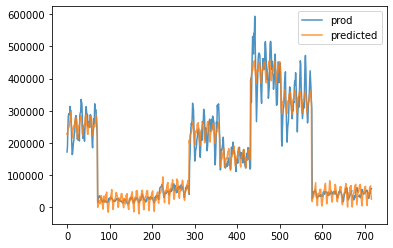

In [ ]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
df_scaled['predicted'] = model.predict(X)
df_scaled[['prod', 'predicted']].plot(alpha=0.8);

print("MAPE : ", mean_absolute_percentage_error(y, df_scaled['predicted']))
print("R2 : ", r2_score(y, df_scaled['predicted']))

**Splitting test and train datasets:**

*Fitting the model 100 times by splitting them randomly into train and test sets and taking the average error, similar to cross validation and bootstrap but with replacement.*

In [ ]:
A = []
B = []
for i in range(0, 100):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)
  model = LinearRegression(fit_intercept=True)
  model.fit(Xtrain, ytrain)
  predicted = model.predict(Xtest)
  A.append(mean_absolute_percentage_error(ytest, predicted))
  B.append(r2_score(ytest, predicted))
print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))

MAPE :  0.27442431349372876
R2 :  0.9356078785773376


**2) With polynomials and interaction terms:**

In [ ]:
A = []
B = []
for i in range(0, 100):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)
  poly_model = LinearRegression(fit_intercept=True)
  poly = PolynomialFeatures(2)
  Xpolytrain = np.concatenate((poly.fit_transform(Xtrain.loc[:, Xtrain.columns.isin(['precip', 'smos', 'temp', 'ndvi'])].values), 
               Xtrain.loc[:, ~Xtrain.columns.isin(['precip', 'smos', 'temp', 'ndvi'])].values), axis = 1)

  Xpolytest = np.concatenate((poly.fit_transform(Xtest.loc[:, Xtest.columns.isin(['precip', 'smos', 'temp', 'ndvi'])].values), 
               Xtest.loc[:, ~Xtest.columns.isin(['precip', 'smos', 'temp', 'ndvi'])].values), axis = 1)
  poly_model.fit(Xpolytrain, ytrain)
  predicted = poly_model.predict(Xpolytest)
  A.append(mean_absolute_percentage_error(ytest, predicted))
  B.append(r2_score(ytest, predicted))
print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))

MAPE :  0.31269991895996646
R2 :  0.9400891233673291


**3) With Regularization - Ridge and Lasso:**

*Though this produces lowest error sometimes, the errors are highly varying*

In [ ]:
from sklearn.linear_model import RidgeCV

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

#model_ridge = linear_model.Ridge(alpha=.5, fit_intercept=True)
r_alphas = np.logspace(0, 5, 100)
model_ridge = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error')

model_ridge.fit(Xtrain, ytrain)
model_ridge = RidgeCV(alphas=model_ridge.alpha_, scoring='neg_mean_squared_error')

model_ridge.fit(Xtrain, ytrain)
predicted = model_ridge.predict(Xtest)

print("Ridge")
print("MAPE : ", mean_squared_error(ytest, predicted))
print("R2 : ", r2_score(ytest, predicted))



Ridge
MAPE :  0.40226612012511576
R2 :  0.9446441370184511


In [ ]:
from sklearn.linear_model import LassoCV

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

model_Lasso = LassoCV(cv=5, random_state=0)

model_Lasso.fit(Xtrain, ytrain)
predicted = model_Lasso.predict(Xtest)

print("Lasso")
print("MAPE : ", mean_absolute_percentage_error(ytest, predicted))
print("R2 : ", r2_score(ytest, predicted))


Lasso
MAPE :  0.16135685067650318
R2 :  0.8225472872563792


**4) Gradient Boosting:**

*This produces the second lowest MAPE around 17% in average for 10 fitting.*

In [ ]:
from xgboost import XGBRegressor
A = []
B = []
for i in range(0,10):

  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)
  XGB = XGBRegressor(500, objective='reg:squarederror')

  XGB.fit(Xtrain, ytrain)

  yfit = XGB.predict(Xtest)
  

  A.append(metrics.mean_absolute_percentage_error(yfit, ytest))
  B.append(r2_score(yfit, ytest))

print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))


MAPE :  0.16425421259209383
R2 :  0.9269334549682562


**5) Dimension reduction with PCA for all the principal components with Random forest:**

In [ ]:
from sklearn.decomposition import PCA

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

for i in range(1, X.shape[1]):
  pca = PCA(n_components = i)
  pca.fit(Xtrain)
  X_pca_train = pca.transform(Xtrain)
  forest = RandomForestRegressor(100)
  forest.fit(X_pca_train, ytrain)
  X_pca_test = pca.transform(Xtest)
  yfit = forest.predict(X_pca_test)
  print(i, metrics.mean_absolute_percentage_error(yfit, ytest), r2_score(yfit, ytest))

**Random forest Parameter tuning with randomized search and cross validation:**

*Though there are lot of parameters listed below, the model performed better when n_estimators = 1000 and keeping the others default. So have used only this one for prediction*

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X, y)

rf_random.best_params_

**Parameter tuning averaging for 100 fits**

**n_estimator = 1000:**

In [ ]:
A = []
B = []
for i in range(0, 100):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

  forest = RandomForestRegressor(1000)

  forest.fit(Xtrain, ytrain)

  yfit = forest.predict(Xtest)
  #print(metrics.mean_absolute_percentage_error(yfit, ytest), r2_score(yfit, ytest))
  A.append(metrics.mean_absolute_percentage_error(yfit, ytest))
  B.append(r2_score(yfit, ytest))
print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))

MAPE :  0.14094902753747257
R2 :  0.9524412672968546


**n_estimator = 100:**

In [ ]:
A = []
B = []
for i in range(0, 100):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

  forest = RandomForestRegressor(500)

  forest.fit(Xtrain, ytrain)

  yfit = forest.predict(Xtest)
  #print(metrics.mean_absolute_percentage_error(yfit, ytest), r2_score(yfit, ytest))
  A.append(metrics.mean_absolute_percentage_error(yfit, ytest))
  B.append(r2_score(yfit, ytest))
print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))

MAPE :  0.14418216422509209
R2 :  0.9489808451701047


**For all the parameters from randomized search:**

In [ ]:
A = []
B = []
for i in range(0, 100):
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.0138)

  forest = RandomForestRegressor(bootstrap = True,
  max_depth = 110,
  max_features = 'sqrt',
  min_samples_leaf = 1,
  min_samples_split = 2,
  n_estimators = 1000)

  forest.fit(Xtrain, ytrain)

  yfit = forest.predict(Xtest)
  A.append(metrics.mean_absolute_percentage_error(yfit, ytest))
  B.append(r2_score(yfit, ytest))
  #print(metrics.mean_absolute_percentage_error(yfit, ytest), r2_score(yfit, ytest))
print("MAPE : ", np.mean(A))
print("R2 : ", np.mean(B))

MAPE :  0.1746441259833059
R2 :  0.9265417283595222


**Conclusion:**

*All in all, Randomforest with 1000 trees outperformed all the other considered models given a random split of train and test data on the given dataset, followed by XGBoosting. Still there are a lot of other models that are left out such as GAMs, SVMs, splines, and Neural Networks(RNN) which may perform better in this set. I will continue exploring them for learning purposes. Thanks for this opportunity, have learned a lot!*